In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd
from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN

In [5]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

In [8]:
output_dir='/rapids/notebooks/host/representations/output/'

In [16]:
import glob

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)


In [17]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions/*.csv')

In [18]:
%%time
cuml_dbscan = daskDBSCAN( eps = 0.75,
                          metric='euclidean',
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(gdf)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 9917.321635484695 seconds ---


AttributeError: 'numpy.ndarray' object has no attribute 'values_host'

In [21]:
labels = trained_DBSCAN.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



Estimated number of clusters: 3444
Estimated number of noise points: 265345


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

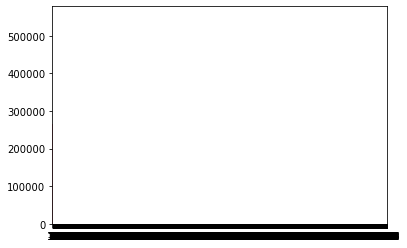

In [23]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_)

rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [25]:
import torch

In [26]:
torch.save(trained_DBSCAN, os.path.join(output_dir,'dask_dbscan_model.bin'))

In [30]:
def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

In [31]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_)

In [32]:
df_labels = index_layer_heads(df_labels)

In [38]:
torch.save(df_labels, os.path.join(output_dir,'dask_dbscan_labels_df.bin'))